# Variational AutoEncoder

Task: Implement and train a probabilistic AutoEncoder called Variational AutoEncoder (VAE) on MNIST. A nice introduction to this topic is [here](https://www.jeremyjordan.me/variational-autoencoders/).

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

cpu


In [3]:
dataset_path = 'datasets'
mnist_transform = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ]) 
# torchvision.datasets.MNIST.__len__ = lambda _ : 10
train_dataset = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [4]:
# Implement Encoder that consists of FC input_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> latent_dim
# You can use LeakyReLU 0.2

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_mu= nn.Linear(hidden_dim, latent_dim)

        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.ln1(x)

        x = self.lrelu(self.fc2(x))
        x = self.ln2(x)

        # x = self.fc3(x)

        return self.fc_mu(x), self.fc_logvar(x)

In [5]:
# Implement Decoder that consists of FC latent_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> output_dim
# You can use Sigmoid and LeakyReLU 0.2

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.lrelu = nn.LeakyReLU(0.2)
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.ln1(x)

        x = self.lrelu(self.fc2(x))
        x = self.ln2(x)

        x = self.fc3(x)

        return self.sigm(x)

In [6]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
        super(Model, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterization(self, mean, logvar):
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)

        return eps * stddev + mean 
                
    def forward(self, x):
        x_clone = x.clone()

        x_mu, x_logvar = self.encoder(x)

        assert x_logvar.shape == x_mu.shape, (x_logvar.shape, x_mu.shape)
        
        x = self.reparameterization(x_mu, x_logvar)

        x = self.decoder(x)

        return x_clone, x, x_mu, x_logvar 

In [7]:
# Loss function for the Gaussian distribution prior is presented in https://arxiv.org/pdf/1907.08956.pdf, Eq. 43.
def cross_entropy(x, x_hat):
    assert x.shape == x_hat.shape

    len = x.shape[0]

    ce = (-1/len) * torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat), dim = 1)

    ce = torch.mean(ce)

    return ce

def loss_function(x, x_hat, mu, logvar, iter = 0):
    kld_weight = 0.4
    rl_weight = 15

    # recons_loss = cross_entropy(x, x_hat)
    recons_loss = torch.nn.functional.mse_loss(x, x_hat)
    recons_loss *= rl_weight

    KLD = torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1)
    KLD = torch.mean(-0.5 * KLD, dim = 0)
    KLD *= kld_weight

    # if iter % 60 == 0:
        # print(f'{recons_loss=} {KLD=}')

    return rl_weight * recons_loss, kld_weight * KLD

In [8]:
def show_images(x, n_samples = 3, x_hat = None):
    x = x.view(batch_size, 28, 28) 
    for i in range(n_samples):
        plt.figure()

        if x_hat is None:
            idx = i

        else:
            x_hat = x_hat.view(batch_size, 28, 28) 

            x = x.detach()
            x_hat = x_hat.detach()

            idx = torch.rand(1) * (batch_size - 1)
            idx = int(idx)

            plt.imshow(x_hat[idx].cpu().numpy())
            plt.figure()

        plt.imshow(x[idx].cpu().numpy())

In [ ]:
latent_dim = int(200 / 2)

print(x_dim, hidden_dim, latent_dim)

encoder = Encoder(
    input_dim = x_dim,
    hidden_dim = hidden_dim,
    latent_dim = latent_dim,
)

decoder = Decoder(
    latent_dim = latent_dim,
    hidden_dim = hidden_dim,
    output_dim = x_dim,
)

model = Model(encoder = encoder, decoder = decoder, latent_dim = latent_dim).to(device)

lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

print([p[0] for p in model.named_parameters()])

784 400 100
['encoder.fc1.weight', 'encoder.fc1.bias', 'encoder.ln1.weight', 'encoder.ln1.bias', 'encoder.fc2.weight', 'encoder.fc2.bias', 'encoder.ln2.weight', 'encoder.ln2.bias', 'encoder.fc_logvar.weight', 'encoder.fc_logvar.bias', 'encoder.fc_mu.weight', 'encoder.fc_mu.bias', 'decoder.fc1.weight', 'decoder.fc1.bias', 'decoder.ln1.weight', 'decoder.ln1.bias', 'decoder.fc2.weight', 'decoder.fc2.bias', 'decoder.ln2.weight', 'decoder.ln2.bias', 'decoder.fc3.weight', 'decoder.fc3.bias']


rloss=tensor(55.9458, grad_fn=<MulBackward0>) kldloss=tensor(4.0025, grad_fn=<MulBackward0>)
rloss=tensor(8.1290, grad_fn=<MulBackward0>) kldloss=tensor(1.8217, grad_fn=<MulBackward0>)
rloss=tensor(5.9559, grad_fn=<MulBackward0>) kldloss=tensor(2.2654, grad_fn=<MulBackward0>)
rloss=tensor(5.5577, grad_fn=<MulBackward0>) kldloss=tensor(2.3555, grad_fn=<MulBackward0>)
rloss=tensor(5.1489, grad_fn=<MulBackward0>) kldloss=tensor(2.4462, grad_fn=<MulBackward0>)
rloss=tensor(4.1812, grad_fn=<MulBackward0>) kldloss=tensor(2.4304, grad_fn=<MulBackward0>)
rloss=tensor(4.3628, grad_fn=<MulBackward0>) kldloss=tensor(2.6144, grad_fn=<MulBackward0>)
rloss=tensor(4.4330, grad_fn=<MulBackward0>) kldloss=tensor(2.6442, grad_fn=<MulBackward0>)
rloss=tensor(4.1466, grad_fn=<MulBackward0>) kldloss=tensor(2.6392, grad_fn=<MulBackward0>)
rloss=tensor(4.0489, grad_fn=<MulBackward0>) kldloss=tensor(2.6699, grad_fn=<MulBackward0>)
rloss=tensor(3.6579, grad_fn=<MulBackward0>) kldloss=tensor(2.6265, grad_fn=<Mu

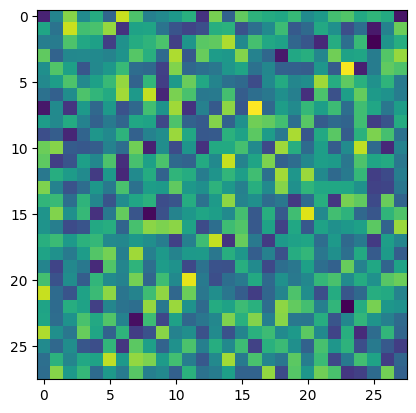

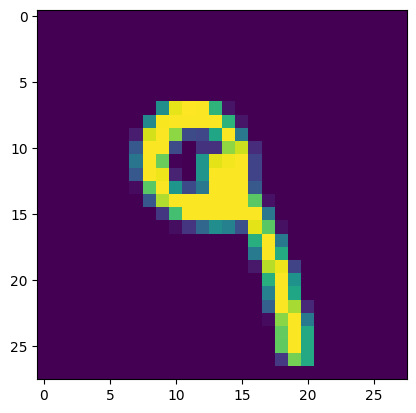

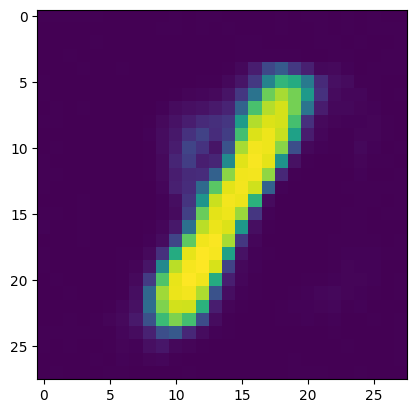

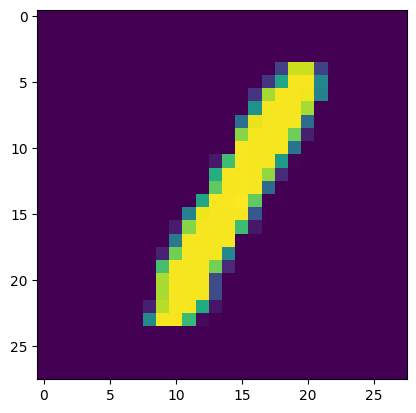

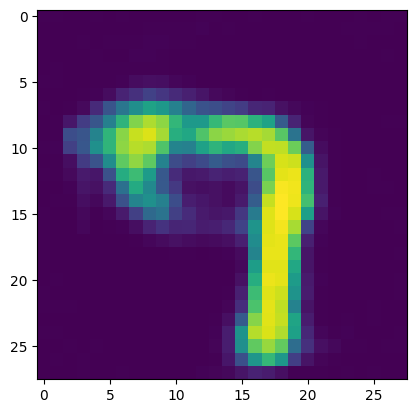

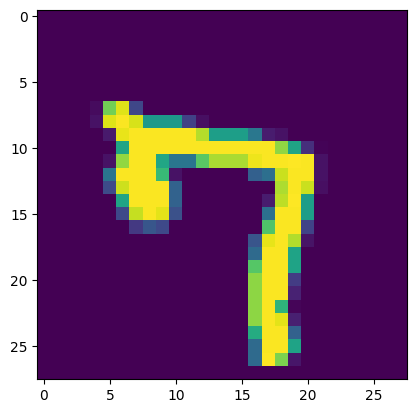

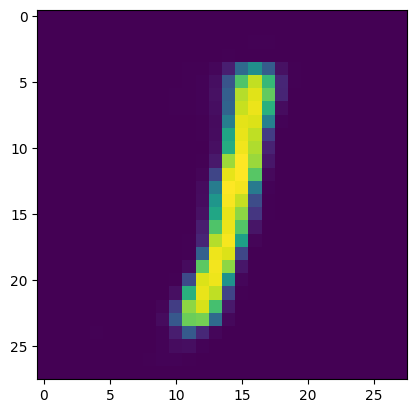

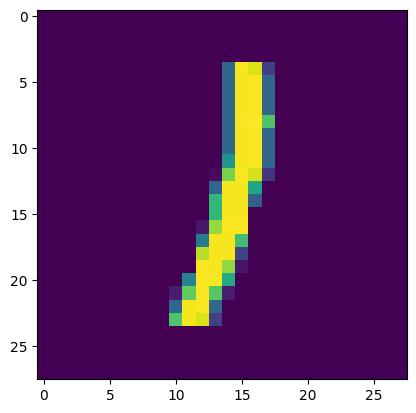

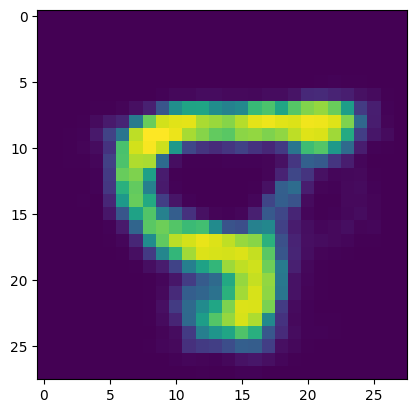

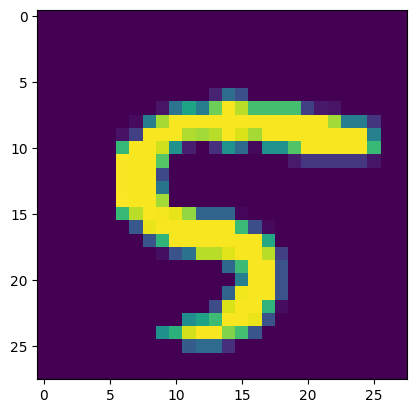

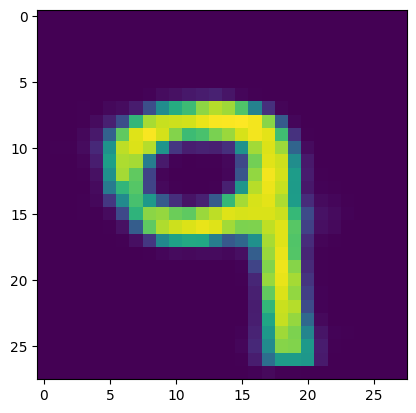

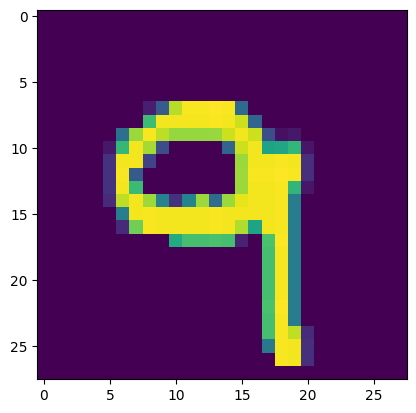

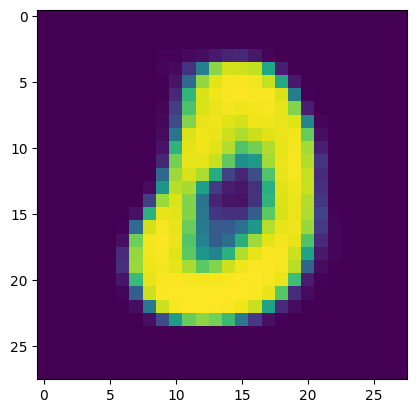

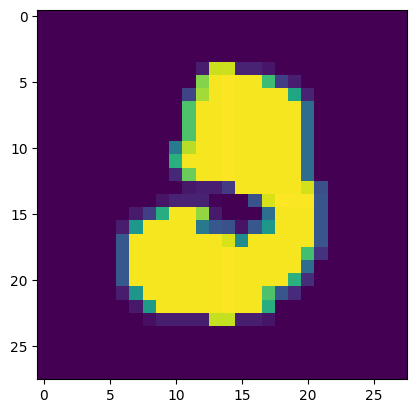

In [10]:
model.train()
epochs = 13

losses = []
for epoch in range(epochs):
    overall_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x, x_hat, mean, log_var = model(x)
        rloss, kldloss = loss_function(x, x_hat, mean, log_var, iter = i)

        if i == 0:
            print(f'{rloss=} {kldloss=}')
            if epoch % 2 == 0: 
                show_images(x, 1, x_hat)

        loss = rloss + kldloss
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        losses += [loss.item()]

    # print("\tEpoch", epoch + 1, "Average Loss: ", overall_loss / (len(train_loader) * batch_size))

In [16]:
import plotly.express as px
fig = px.line(y = losses, labels = {'y':'loss'})
fig.show()

In [ ]:
model.eval()

embeddings = []
labels = []
with torch.no_grad():
    for i, (x, label) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x, x_hat, _, _ = model(x)

        x_mu, x_logvar = model.encoder(x)
        embedding = model.reparameterization(x_mu, x_logvar)
        embeddings += [embedding.cpu()]
        labels += [label.cpu()]

embeddings = np.array(embeddings).reshape(-1, latent_dim)
labels = np.array(labels).reshape(-1)
# embeddings[:3, : 20]

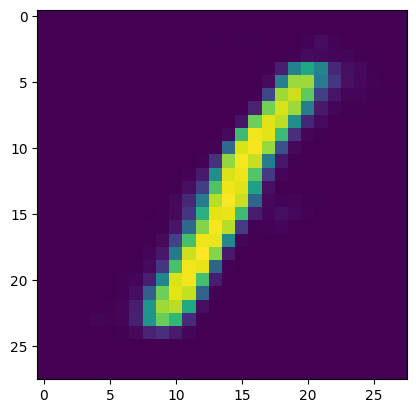

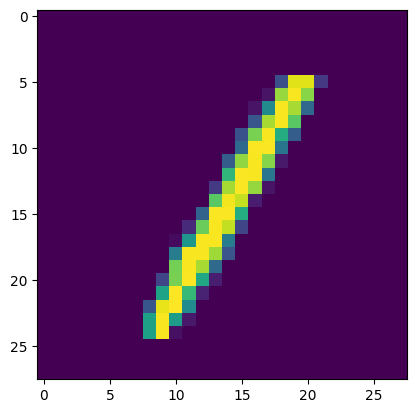

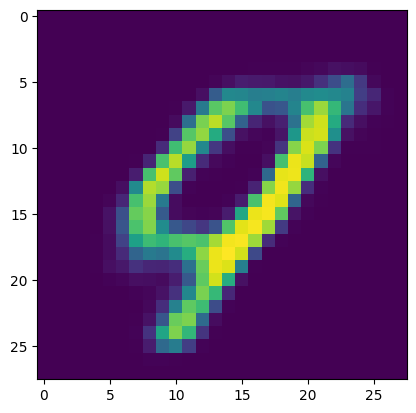

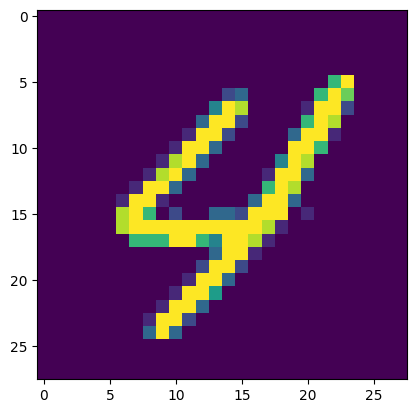

In [18]:
show_images(x, 2, x_hat)

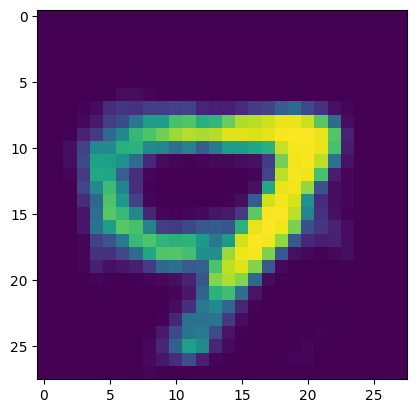

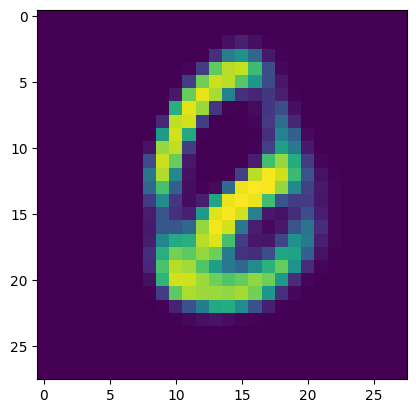

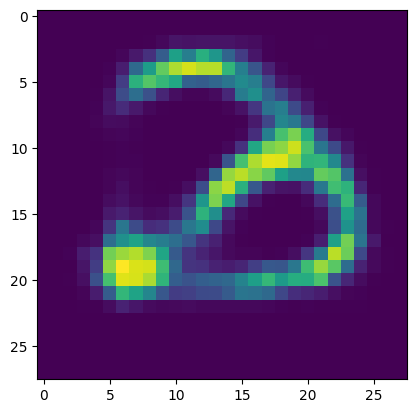

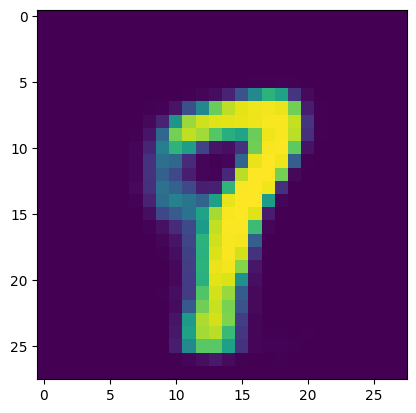

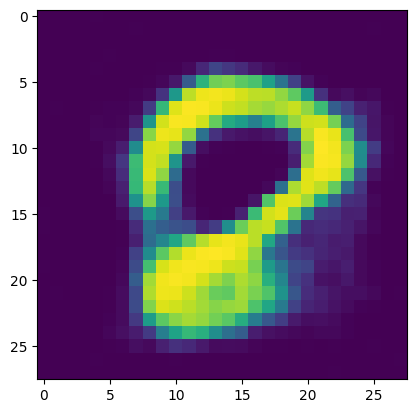

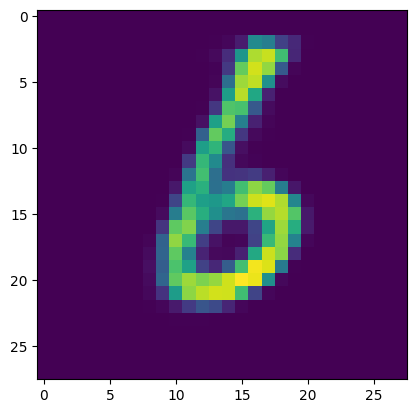

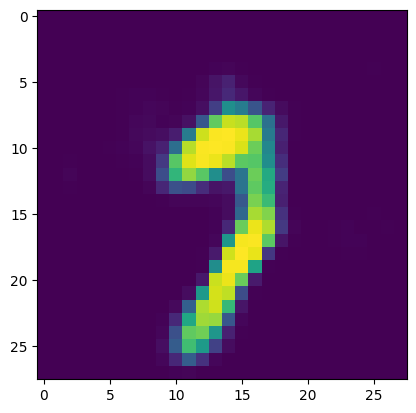

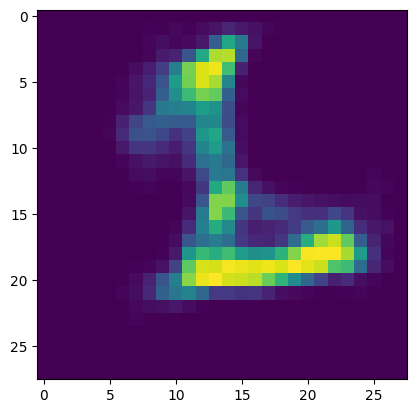

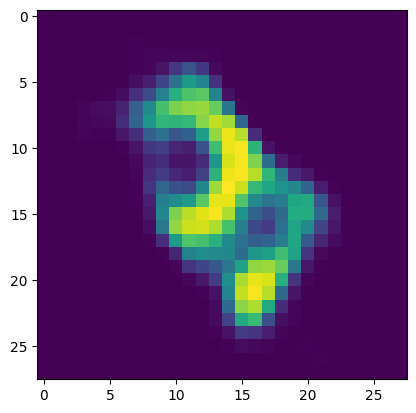

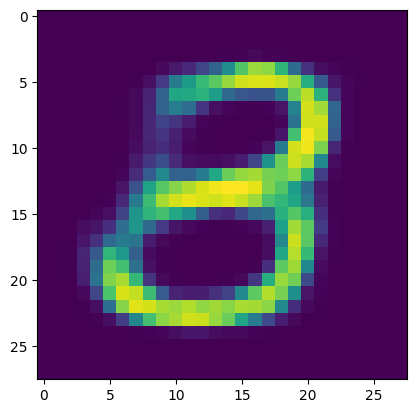

In [ ]:
# Sample random noise and generate images from it
variance_const = 4
random_embeddings = (torch.rand((batch_size, latent_dim), requires_grad = False, device = device) - 0.5) * variance_const

random_imgs = model.decoder(random_embeddings)

show_images(random_imgs.detach(), n_samples = 10)

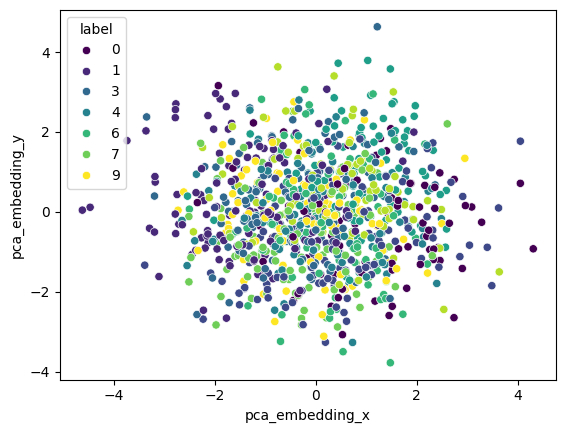

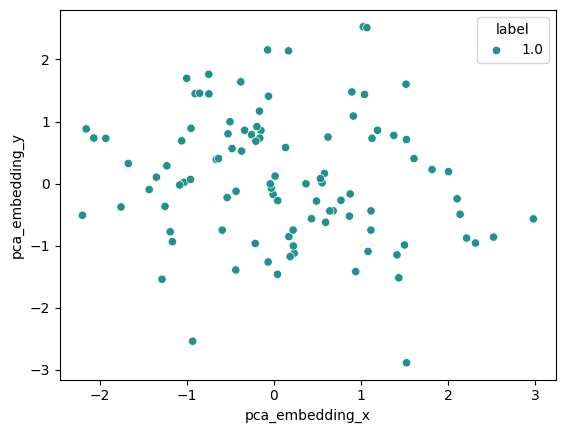

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# PCA
real_examples = 1000
embeddings, labels = embeddings[:real_examples], labels[:real_examples]

pca = PCA(n_components = 2)
pca.fit(embeddings)

def show_embeddings(pca, embeddings, labels):
    pca_embeddings = pca.transform(embeddings)

    df_pca = pd.DataFrame(pca_embeddings, columns=["pca_embedding_x", "pca_embedding_y"])
    df_pca["label"] = labels 

    plt.figure()
    sns.scatterplot(data=df_pca, x="pca_embedding_x", y="pca_embedding_y", hue="label", palette="viridis")
    plt.show()

show_embeddings(pca, embeddings, labels)
show_embeddings(pca, random_embeddings.cpu(), np.ones(batch_size))